# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from math import sqrt
import matplotlib.pyplot as plt
import pickle

import warnings #ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/home/abdelmoez/miniconda3/envs/lara/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Reading data file from task 2

In [2]:
data = pd.read_csv('./transformed_data.csv')

# Cleaning data and adding neighbors pos and vel

In [3]:
for i,j in zip(data.frame_id,data.neighbor_id):#loop over frameid and neighbor id
    j = int(j)#switch neighbor id to int so it doesn't show matching errors
    neg = data[np.logical_and(data.frame_id == i, data.ped_no == j)].iloc[:,[2,3,5,6]].values.tolist()#get the data of the neighbor in the current frame
    if not len(neg):#If no data retuned remove the frame because it is labeled wrong NB.this problem can be fixed but will take too much time to debug
        data=data[data.frame_id!=i]

In [4]:
poscols = [2,3,5,6]#the indicies of the required cols for the neighbor data
n = []#create an empty list to be filled with the neighbor data
for i,j in zip(data.frame_id,data.neighbor_id):# same as the previous loop but this time filling the data(had to be in 2 loops because if we use the non filterd data some of the unwanted frames get in the data)
    j = int(j)
    neg = data[np.logical_and(data.frame_id == i, data.ped_no == j)].iloc[:,poscols].values.tolist()[0]
    n.append(neg)#fill the empty list

In [5]:
newcols = 'n_' + data.columns[poscols]#create a list of the names of the columns simply by adding n_ at the beginning of the names of the curent cols
data[newcols] = n #create the new cols and assign the saved data to them

# Get train and test data

In [6]:
def get_train_test_data(data):
    data.sort_values(by=['frame_id', 'ped_no'])#sort the data by frame then ped id
    x = []
    y = []
    for i in data.ped_no.unique():#loop over each ped
        d = data[data.ped_no==i]#get the data of each ped
        for j in range(d.shape[0]-19):#loop over each the differnce between the no of frames for each ped and 19 in order to make pairs of 8 frames then 12 frames
            x.append(d[j:8+j].values.flatten())#get all the data for the 8 frames
            y.append(d[8+j:20+j].iloc[:,[2,3]].values.flatten())#get just the pos data for the next 12 frames

    return np.asarray(x),np.asarray(y)
X,y = get_train_test_data(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)# split the data to 75% train and the rest for test

# Training Ridge Regression and calculating R^2 score

In [7]:
RGregr = MultiOutputRegressor(Ridge(random_state=123)).fit(X_train, y_train)# create a multi out put regressor with Ridge regression and fit for the train data

pickle.dump(RGregr, open('RGregr', 'wb'))#save the model to a pickle file to preserve its content
RGregr = pickle.load(open('RGregr', 'rb'))#load the model to make sure it is saved correctly
print("R^2 for Ridge: ",RGregr.score(X_test,y_test))#get the r2 score for this model using the test data

R^2 for Ridge:  0.9454982232238384


# Training XGBoost and calculating R^2 score

In [8]:
XGregr = MultiOutputRegressor(XGBRegressor()).fit(X_train, y_train)# create a multi out put regressor with XGBoost regressor and fit for the train data

pickle.dump(XGregr, open('XGregr', 'wb'))#save the model to a pickle file to preserve its content
XGregr = pickle.load(open('XGregr', 'rb'))#load the model to make sure it is saved correctly
print("R^2 for XGBoost: ",XGregr.score(X_test,y_test))#get the r2 score for this model using the test data

R^2 for XGBoost:  0.9764311733635612


In [9]:
SVMregr = MultiOutputRegressor(SVR()).fit(X_train, y_train)# create a multi out put regressor with SVM regressor and fit for the train data

pickle.dump(SVMregr, open('SVMregr', 'wb'))#save the model to a pickle file to preserve its content
SVMregr = pickle.load(open('SVMregr', 'rb'))#load the model to make sure it is saved correctly
print("R^2 for SVM: ",SVMregr.score(X_test,y_test))#get the r2 score for this model using the test data

R^2 for SVM:  0.05008168187806192


# Get Predictions

In [10]:
y_pred = XGregr.predict(X_test)#get the predictions for the test data using the XGBoost model because it has the best performance

# Calculate R^2, average Mean Squared Error and for each frame of XGBOOST

In [11]:
MSE = mean_squared_error(y_test,y_pred)#calculate average MSE accross all frames
print('Averge MSE of XGBoost = {}'.format(MSE))
print('Averge MSE of Ridge = {}'.format(mean_squared_error(y_test,RGregr.predict(X_test))))
print('Averge MSE of Ridge = {}'.format(mean_squared_error(y_test,SVMregr.predict(X_test))))

Averge MSE of XGBoost = 0.20830110231886975
Averge MSE of Ridge = 0.5406154410801687
Averge MSE of Ridge = 10.521562203240997


In [12]:
MSE_Raw = mean_squared_error(y_test,y_pred,multioutput='raw_values')#calculate the MSE for each frame and each coordinate
MSE_Raw = np.resize(MSE_Raw,(12,2))#resize the MSE in readable format
print('MSE of XGBoost for each frame is : \n',MSE_Raw)
print('MSE of Ridge for each frame is : \n',np.resize(mean_squared_error(y_test,RGregr.predict(X_test),multioutput='raw_values'),(12,2)))

MSE of XGBoost for each frame is : 
 [[0.11061717 0.00843994]
 [0.12328492 0.0081802 ]
 [0.16176216 0.01496502]
 [0.17318139 0.01992652]
 [0.26406592 0.02643934]
 [0.28893404 0.05621594]
 [0.37319752 0.05464988]
 [0.36990216 0.06117673]
 [0.50130609 0.07929234]
 [0.57960747 0.1004494 ]
 [0.58719505 0.10021351]
 [0.8103597  0.12586406]]
MSE of Ridge for each frame is : 
 [[0.08132842 0.00547071]
 [0.10599738 0.00957006]
 [0.19521962 0.01966034]
 [0.29885336 0.03392397]
 [0.44480022 0.05453443]
 [0.63674431 0.08232188]
 [0.83311097 0.11075402]
 [1.0834654  0.14401709]
 [1.35367321 0.18117185]
 [1.71419318 0.2380658 ]
 [2.13030917 0.29661915]
 [2.55748111 0.36348492]]


# Get ADE, FDE and Near Collision percentage

In [13]:
def get_ADE(y_test,y_pred):#the function to calculate the ADE
    sum = 0
    for i,j in zip(np.resize(y_test,(y_test.shape[0],12,2)),np.resize(y_pred,(y_pred.shape[0],12,2))):# loop over the prediction and actual value then calculate distances
        for t,p in zip(i,j):
            sum+=sqrt((p[0]-t[0])**2 + (p[1]-t[1])**2)
    ADE = sum/(y_test.shape[0]*12)#average the distances
    return ADE
ADE = get_ADE(y_test,y_pred)
print('ADE of XGBoost = {}'.format(ADE))
print('ADE of Ridge = {}'.format(get_ADE(y_test,RGregr.predict(X_test))))

ADE of XGBoost = 0.43805054298927676
ADE of Ridge = 0.6885041731246284


In [14]:
def get_FDE(y_test,y_pred):#the function to calculate the FDE
    sum = 0
    for i,j in zip(np.resize(y_test,(y_test.shape[0],12,2)),np.resize(y_pred,(y_pred.shape[0],12,2))):# loop over the prediction and actual value then calculate distances between the last frame only
        t = i[-1]
        p = j[-1]
        sum+=sqrt((p[0]-t[0])**2 + (p[1]-t[1])**2)
    FDE = sum/(y_test.shape[0])
    return FDE
FDE = get_FDE(y_test,y_pred)
print('FDE of XGBoost = {}'.format(FDE))
print('FDE of Ridge = {}'.format(get_FDE(y_test,RGregr.predict(X_test))))

FDE of XGBoost = 0.6415055302072094
FDE of Ridge = 1.3015781917507252


In [15]:
def get_coll_percent(X,model):
    y_pred = model.predict(X)
    frames = np.resize(X,(X.shape[0]*8,21)).T[0]#resize the frames to make it usable
    frames = np.resize(frames,(frames.shape[0]//8,8))
    p = np.resize(X,(X.shape[0]*8,21)).T[1]#resize the p id to make it usable
    p = np.resize(p,(p.shape[0]//8,8))
    f = []
    peds = []
    for i,j in zip(frames,p):
        f.append(np.arange(i[-1]+10,i[-1]+130,10))#calculate the number of the predicted frames
        peds.append([j[0]]*12)#get p id array the same size of the predictions
    y_pred = np.resize(y_pred.flatten(),(y_pred.shape[0]*12,2))
    
    data = pd.DataFrame()#create a data frame with all the data to use its filtering features
    data['f'] = np.asarray(f).flatten()
    data['ped_pos_x'] = y_pred.T[0]
    data['ped_pos_y'] = y_pred.T[1]
    data['p_id'] = np.asarray(peds).flatten()
    count = 0
    for i in data.values:#loop over the data generated and calculate for each frame predicted the distances between all the other neighbors and count when it gets <0.1
        pos = np.asarray(i[[1,2]])
        neg = data[data.p_id != i[-1]]
        neg = neg[np.logical_not(neg[['f','p_id']].duplicated())]
        neg = neg[neg.f == i[0]].iloc[:,[1,2]].values
        x = (neg - pos)**2
        x = np.sqrt(x.T[0]+x.T[1]).T
        x = np.where(x<0.1)[0].shape[0]
        count+=x
    return (count/data[np.logical_not(data[['f','p_id']].duplicated())].shape[0])*100,data#return the percentage from the predicted frames without redunduncy and also return this formated array to be used in the visualization
coll_percent,df = get_coll_percent(X_test,XGregr)
ridge_percent,df_ridge = get_coll_percent(X_test,RGregr)

In [16]:
print('Near Collision Percentage of XGBoost = {}%'.format(coll_percent))
print('Near Collision Percentage of Ridge = {}%'.format(ridge_percent))

Near Collision Percentage of XGBoost = 0.37209302325581395%
Near Collision Percentage of Ridge = 0.4186046511627907%


# Format data for visualization

In [17]:
fr =df[np.logical_not(df[['f','p_id']].duplicated())].f#get all the frames
start_frame = []#empty list to store possible start frames
for i in fr:#loop over frames
    if df[df.f==i].p_id.unique().shape[0]>3:#check if frame has more than 3 peds
        start_frame.append(i)#add only if condition happens
for i in start_frame:#loop over possible frames to get a good frame not empty 
    end_frame = i+120
    preds = df[np.logical_and(df.f.isin(np.arange(i,end_frame,10)),np.logical_not(df[['f','p_id']].duplicated()))]#store the data for plot predictions
    if preds.shape[0]>=48:
        print('found')
        break
true = data[np.logical_and(data.frame_id.isin(preds.f), data.ped_no.isin(preds.p_id))].sort_values(by=['ped_no']).sort_values(by='frame_id')#store data of actual
preds_rid = df_ridge[np.logical_and(df_ridge.f.isin(preds.f), df_ridge.p_id.isin(preds.p_id))].sort_values(by=['p_id']).sort_values(by='f')

found


In [18]:
preds_pos = []#reshape the pos data to be used in the plots
preds_ridge_pos = []
true_pos = []
for i in preds.p_id.unique():
    preds_pos.append((preds[preds.p_id==i].iloc[:,[1,2]].values,i))
    preds_ridge_pos.append((preds_rid[preds_rid.p_id==i].iloc[:,[1,2]].values,i))
    true_pos.append(true[true.ped_no==i].iloc[:,[2,3]].values)

# Plot scatter for prediction and line for actual path

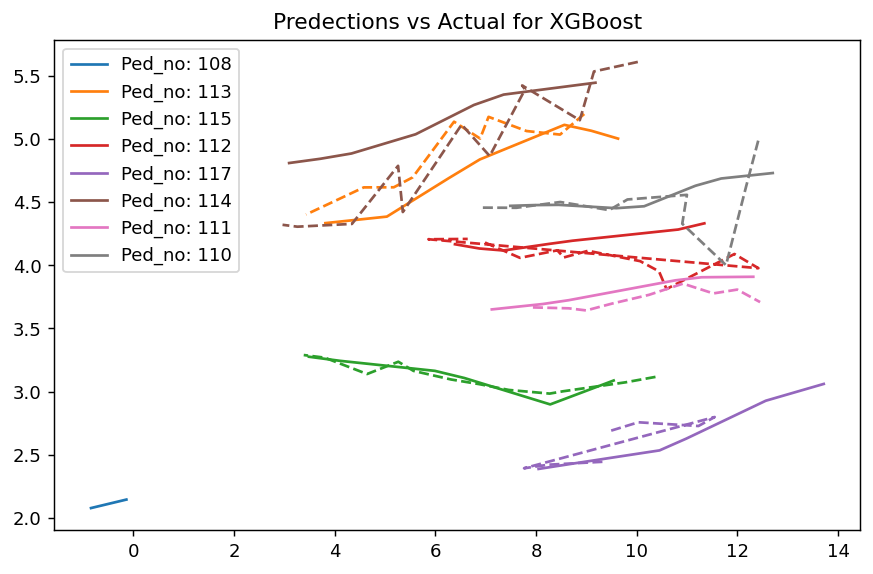

In [19]:
plt.figure(figsize=(8,5),dpi = 130)#create a figure to plot all in one figure
for i,j in zip(true_pos,preds_pos):#loop over 12 frames and plot every ped
    p =plt.plot(i.T[0],i.T[1],label='Ped_no: {}'.format(int(j[1])))
    plt.plot(j[0].T[0],j[0].T[1],linestyle='dashed',color = p[0].get_color())
plt.title('Predections vs Actual for XGBoost')
plt.legend()#show the legend
plt.show()#draw the plot

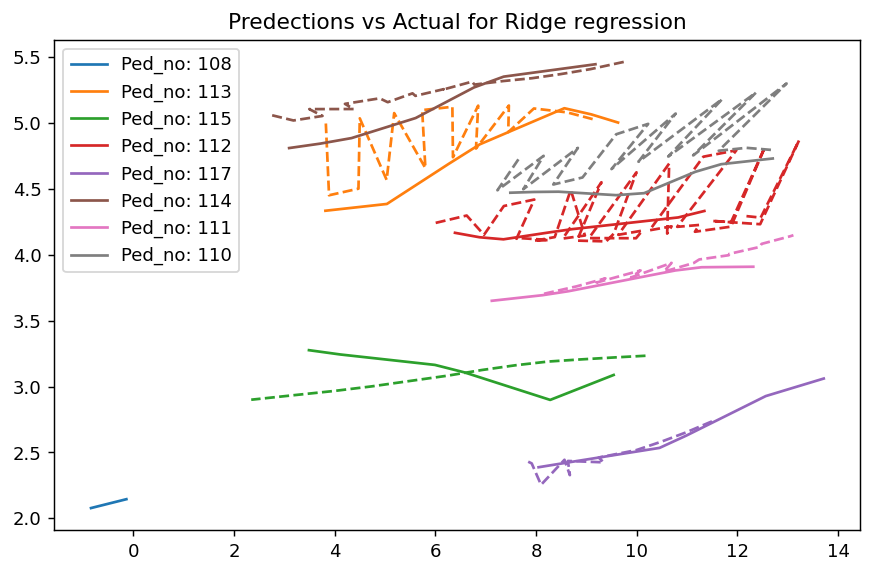

In [20]:
plt.figure(figsize=(8,5),dpi = 130)#create a figure to plot all in one figure
for i,j in zip(true_pos,preds_ridge_pos):#loop over 12 frames and plot every ped
    p =plt.plot(i.T[0],i.T[1],label='Ped_no: {}'.format(int(j[1])))
    plt.plot(j[0].T[0],j[0].T[1],linestyle='dashed',color = p[0].get_color())
plt.title('Predections vs Actual for Ridge regression')
plt.legend()#show the legend
plt.show()#draw the plot